In [45]:
import os
import warnings

# CRITICAL: Set these BEFORE importing any other libraries
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN custom operations
warnings.filterwarnings('ignore')

# Now import everything else
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr

print("✓ Core libraries loaded")

# Try importing optional libraries with proper error handling
XGBOOST_AVAILABLE = False
LIGHTGBM_AVAILABLE = False
TENSORFLOW_AVAILABLE = False

try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("✗ XGBoost not available (optional)")

try:
    from lightgbm import LGBMRegressor
    LIGHTGBM_AVAILABLE = True
    print("✓ LightGBM available")
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("✗ LightGBM not available (optional)")

try:
    # Additional TensorFlow-specific suppression
    import logging
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    
    import tensorflow as tf
    tf.get_logger().setLevel('ERROR')
    tf.autograph.set_verbosity(0)
    
    from tensorflow import keras
    from tensorflow.keras import layers
    
    TENSORFLOW_AVAILABLE = True
    print("✓ TensorFlow available (warnings suppressed)")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("✗ TensorFlow not available (optional)")

print("\n" + "="*80)
print("SETUP COMPLETE - All warnings suppressed!")
print("="*80)
# --- Add near your imports (once) ---
from scipy.stats import spearmanr

def _safe_spearman(y_true, y_pred):
    try:
        v = spearmanr(y_true, y_pred).correlation
        # Handle nan/inf gracefully
        return float(v) if np.isfinite(v) else 0.0
    except Exception:
        return 0.0

✓ Core libraries loaded
✓ XGBoost available
✓ LightGBM available
✓ TensorFlow available (warnings suppressed)

SETUP COMPLETE - All warnings suppressed!


In [2]:
# --- Load relevant data files ---
import pandas as pd

# Main feature and label tables
train = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/train.csv')
test = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/test.csv')
train_labels = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/train_labels.csv')
target_pairs = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/target_pairs.csv')

# Display basic info
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Target pairs shape: {target_pairs.shape}")


Train shape: (1961, 558)
Test shape: (134, 559)
Train labels shape: (1961, 425)
Target pairs shape: (424, 3)


In [3]:
# Show first few rows of each
print("\n--- Train ---")
display(train.head(5))

print("\n--- Train Labels ---")
display(train_labels.head(5))

print("\n--- Target Pairs ---")
display(target_pairs.head(5))



--- Train ---


,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,FX_GBPCAD,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP
0,0,2264.5,7205.0,2570.0,3349.0,NaN,NaN,NaN,NaN,NaN,...,1.699987,0.776874,0.888115,0.689954,0.066653,0.090582,0.119630,0.078135,13.822740,0.059163
1,1,2228.0,7147.0,2579.0,3327.0,NaN,NaN,NaN,NaN,NaN,...,1.695279,0.778682,0.889488,0.692628,0.067354,0.091297,0.120520,0.079066,13.888146,0.059895
2,2,2250.0,7188.5,2587.0,3362.0,4684.0,4691.0,4684.0,3363.0,3367.0,...,1.692724,0.780186,0.894004,0.697490,0.067394,0.091478,0.120809,0.079287,13.983675,0.060037
3,3,2202.5,7121.0,2540.0,3354.0,4728.0,4737.0,4729.0,3430.0,3426.0,...,1.683111,0.785329,0.889439,0.698502,0.067639,0.091558,0.121021,0.079285,14.035571,0.059983
4,4,2175.0,7125.0,2604.0,3386.0,NaN,NaN,NaN,NaN,NaN,...,1.684816,0.787264,0.891042,0.701485,0.067443,0.091266,0.121055,0.078925,14.013760,0.059503



--- Train Labels ---


,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0,0.005948,-0.002851,-0.004675,-0.000639,NaN,NaN,-0.006729,0.006066,NaN,...,NaN,0.021239,-0.005595,NaN,-0.004628,0.033793,NaN,0.038234,NaN,0.027310
1,1,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.003377,0.021372,-0.001517,0.012846,0.010547,0.030527,-0.000764,0.025021,0.003548,0.020940
2,2,0.001048,0.023836,-0.008934,-0.022060,NaN,NaN,0.037449,0.007658,NaN,...,-0.006712,0.009308,0.001857,-0.012761,-0.002345,0.017529,-0.005394,0.004835,-0.009075,0.001706
3,3,0.001700,-0.024618,0.011943,0.004778,NaN,NaN,-0.012519,-0.016896,NaN,...,NaN,0.036880,-0.015189,NaN,0.008118,0.001079,NaN,-0.015102,NaN,-0.033010
4,4,-0.003272,0.005234,0.006856,0.013312,0.023953,0.010681,-0.011649,0.002019,0.003897,...,NaN,0.004937,NaN,-0.006673,-0.016105,-0.004885,NaN,NaN,0.009514,NaN



--- Target Pairs ---


,target,lag,pair
0,target_0,1,US_Stock_VT_adj_close
1,target_1,1,LME_PB_Close - US_Stock_VT_adj_close
2,target_2,1,LME_CA_Close - LME_ZS_Close
3,target_3,1,LME_AH_Close - LME_ZS_Close
4,target_4,1,LME_AH_Close - JPX_Gold_Standard_Futures_Close


In [4]:
# Check basic structure
print(train.info())   # column names & types
print(train.describe().T.head())  # numeric summary

# Check for duplicates or date gaps
print("Unique date_ids:", train['date_id'].nunique())
print("Min/Max date_id:", train['date_id'].min(), train['date_id'].max())
print("Any duplicates?", train['date_id'].duplicated().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Columns: 558 entries, date_id to FX_ZARGBP
dtypes: float64(557), int64(1)
memory usage: 8.3 MB
None
               count         mean          std     min       25%      50%  \
date_id       1961.0   980.000000   566.236258     0.0   490.000   980.00   
LME_AH_Close  1910.0  2252.202853   398.544566  1462.0  1925.250  2245.50   
LME_CA_Close  1910.0  7928.229026  1523.186335  4630.0  6396.125  8260.75   
LME_PB_Close  1910.0  2085.848576   183.154551  1585.5  1973.000  2070.75   
LME_ZS_Close  1910.0  2795.022628   445.009643  1815.5  2479.500  2771.00   

                   75%      max  
date_id       1470.000   1960.0  
LME_AH_Close  2512.000   3849.0  
LME_CA_Close  9323.375  10889.0  
LME_PB_Close  2188.000   2681.0  
LME_ZS_Close  3031.000   4498.5  
Unique date_ids: 1961
Min/Max date_id: 0 1960
Any duplicates? False


In [5]:
# Check the datatypes first
print(train.dtypes.value_counts())

# Find columns that are NOT numeric
non_numeric_cols = train.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Total non-numeric columns: {len(non_numeric_cols)}")

# If there are any, display them
if non_numeric_cols:
    print("\nNon-numeric columns found:")
    print(non_numeric_cols)
else:
    print("\n All columns are numeric.")



float64    557
int64        1
Name: count, dtype: int64
Total non-numeric columns: 0

 All columns are numeric.


In [6]:
# Check for hidden text values in numeric-looking columns
suspicious_columns = []

for col in train.columns:
    # Count how many values cannot be converted to numeric
    non_numeric_count = pd.to_numeric(train[col], errors='coerce').isna().sum()
    
    # Skip NaNs that are true missing values
    true_nans = train[col].isna().sum()
    
    if non_numeric_count > true_nans:
        suspicious_columns.append(col)
        print(f"{col}: {non_numeric_count - true_nans} non-numeric entries detected")

if not suspicious_columns:
    print("\n No hidden non-numeric entries found — dataset is clean.")



 No hidden non-numeric entries found — dataset is clean.


In [7]:
# Group count per lag
target_count_by_lag = target_pairs['lag'].value_counts().sort_index()
print("Targets per Lag:\n", target_count_by_lag)

# Identify feature group in each pair
def get_group(pair):
    if 'LME' in pair: return 'LME'
    elif 'JPX' in pair: return 'JPX'
    elif 'US_' in pair: return 'US'
    elif 'FX_' in pair: return 'FX'
    else: return 'Other'

target_pairs['group'] = target_pairs['pair'].apply(get_group)
group_summary = target_pairs.groupby(['lag', 'group']).size().unstack().fillna(0)
display(group_summary)


Targets per Lag:
 lag
1    106
2    106
3    106
4    106
Name: count, dtype: int64


group,FX,JPX,LME,US
lag,,,,
1,0.0,36.0,69.0,1.0
2,0.0,30.0,75.0,1.0
3,1.0,33.0,72.0,0.0
4,1.0,34.0,71.0,0.0


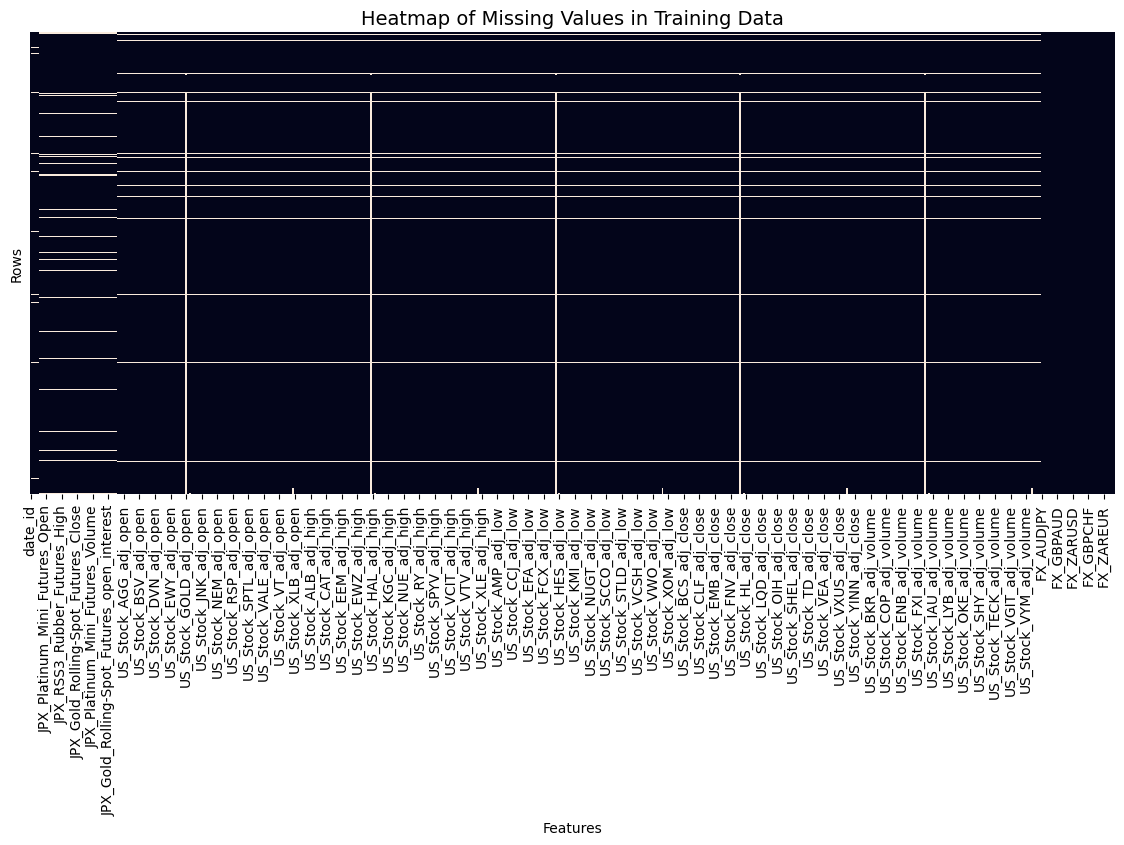

<Axes: >

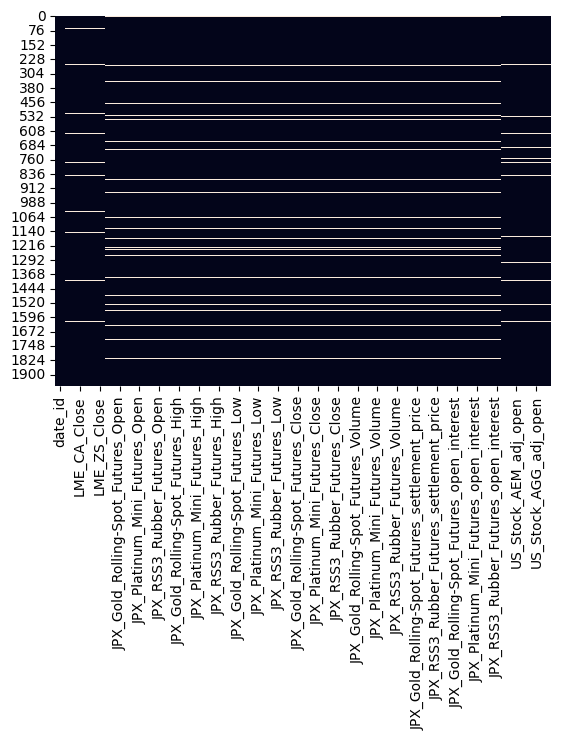

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Heatmap of missing values ---
plt.figure(figsize=(14, 6))
sns.heatmap(train.isna(), cbar=False, yticklabels=False)
plt.title("Heatmap of Missing Values in Training Data", fontsize=14)
plt.xlabel("Features")
plt.ylabel("Rows")
plt.show()
sns.heatmap(train.iloc[:, :50].isna(), cbar=False)

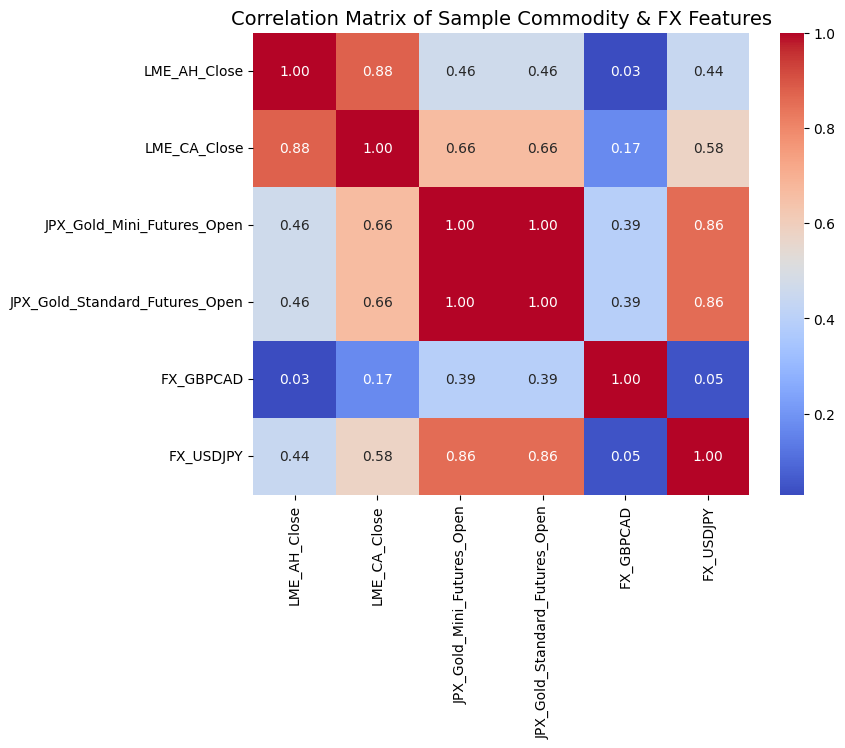

In [9]:
# --- Correlation matrix for selected features ---
sample_features = [
    'LME_AH_Close', 'LME_CA_Close', 'JPX_Gold_Mini_Futures_Open', 
    'JPX_Gold_Standard_Futures_Open', 'FX_GBPCAD', 'FX_USDJPY'
]

plt.figure(figsize=(8, 6))
corr = train[sample_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Sample Commodity & FX Features", fontsize=14)
plt.show()


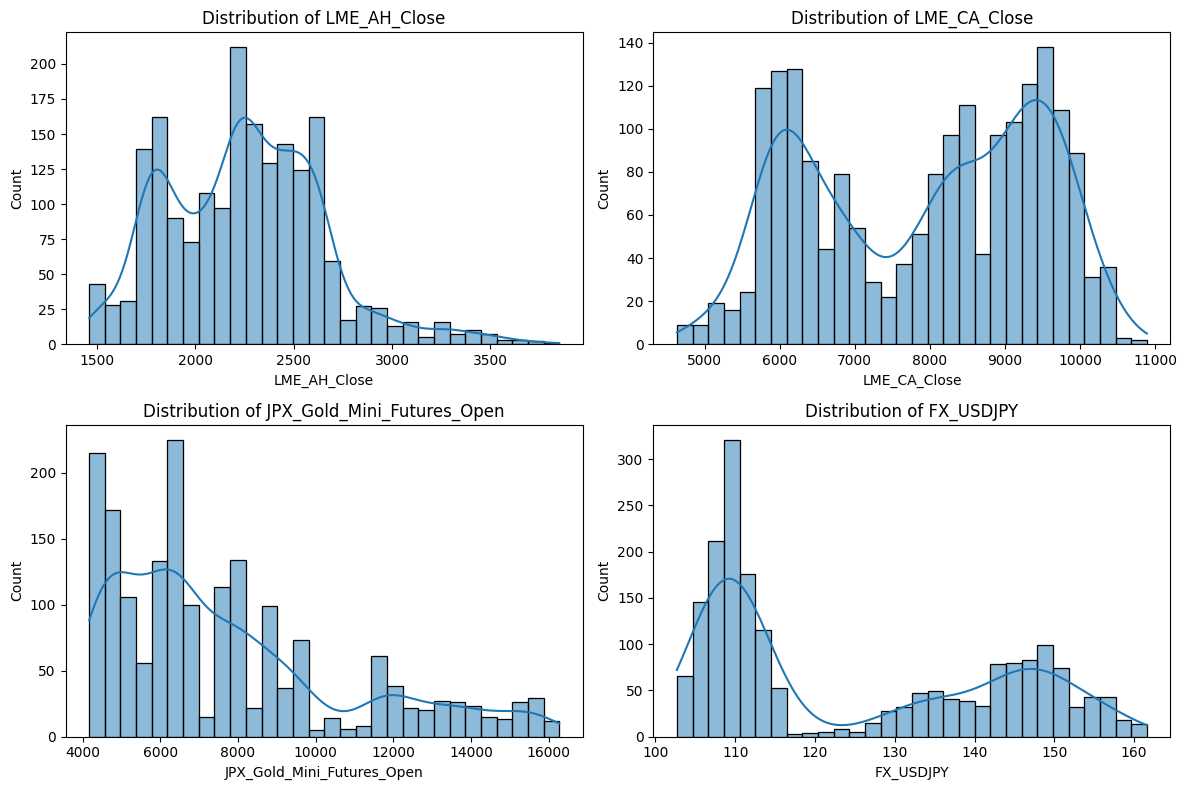

In [10]:
# --- Distribution plots of key features ---
key_features = ['LME_AH_Close', 'LME_CA_Close', 'JPX_Gold_Mini_Futures_Open', 'FX_USDJPY']

plt.figure(figsize=(12, 8))
for i, col in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


In [11]:
# Calculate missing ratio for every column
missing_ratio = train.isnull().mean() * 100

# Sort descending
missing_sorted = missing_ratio.sort_values(ascending=False)

# Display top 15 columns with most missing data
print("Top 15 columns with highest missing percentages:\n")
display(missing_sorted.head(15))


Top 15 columns with highest missing percentages:



US_Stock_GOLD_adj_volume                          87.353391
US_Stock_GOLD_adj_open                            87.353391
US_Stock_GOLD_adj_high                            87.353391
US_Stock_GOLD_adj_low                             87.353391
US_Stock_GOLD_adj_close                           87.353391
JPX_RSS3_Rubber_Futures_High                       5.915349
JPX_Gold_Mini_Futures_Low                          5.915349
JPX_Gold_Rolling-Spot_Futures_Low                  5.915349
JPX_Gold_Rolling-Spot_Futures_Close                5.915349
JPX_Gold_Standard_Futures_Close                    5.915349
JPX_Platinum_Mini_Futures_Close                    5.915349
JPX_Gold_Mini_Futures_settlement_price             5.915349
JPX_Gold_Rolling-Spot_Futures_settlement_price     5.915349
JPX_Platinum_Mini_Futures_settlement_price         5.915349
JPX_RSS3_Rubber_Futures_settlement_price           5.915349
dtype: float64

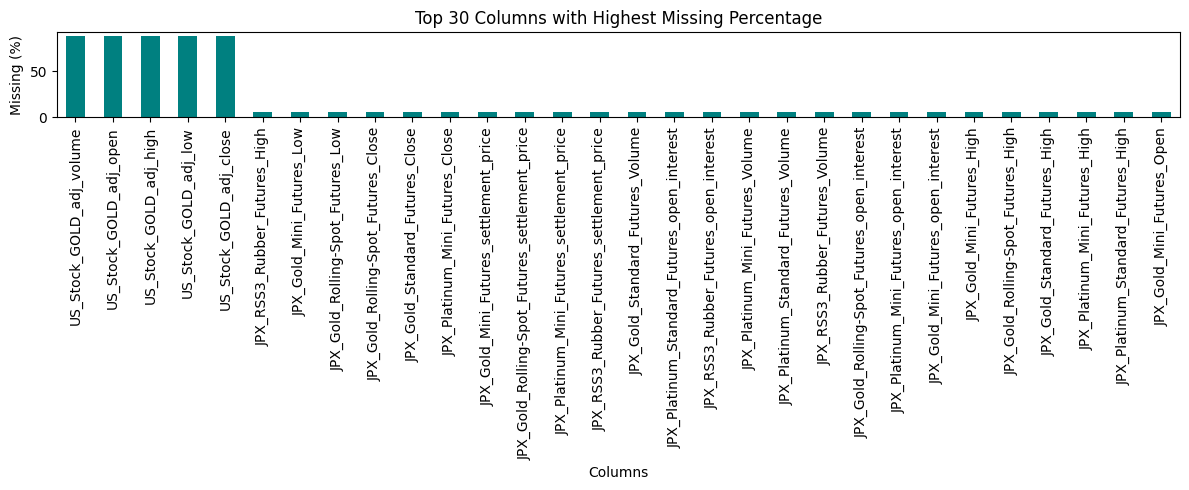

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
missing_sorted.head(30).plot(kind='bar', color='teal')
plt.title("Top 30 Columns with Highest Missing Percentage")
plt.ylabel("Missing (%)")
plt.xlabel("Columns")
plt.tight_layout()
plt.show()

In [13]:
groups = {
    'LME': [c for c in train.columns if c.startswith('LME')],
    'JPX': [c for c in train.columns if c.startswith('JPX')],
    'US':  [c for c in train.columns if c.startswith('US')],
    'FX':  [c for c in train.columns if c.startswith('FX')],
}

group_missing = {g: train[v].isnull().mean().mean() * 100 for g,v in groups.items()}
print("Average Missing Percentage by Group:\n")
for group, val in group_missing.items():
    print(f"{group}: {val:.2f}%")


Average Missing Percentage by Group:

LME: 2.60%
JPX: 5.92%
US: 4.32%
FX: 0.00%


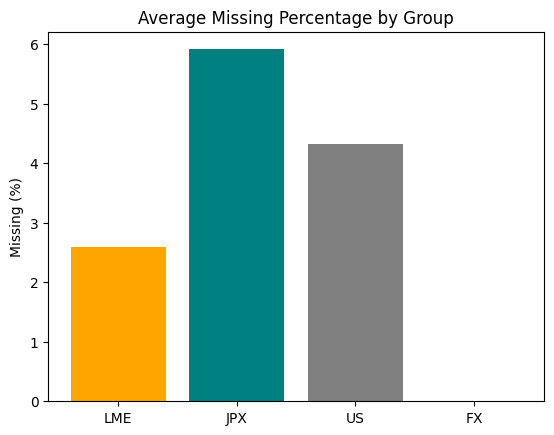

In [14]:
plt.bar(group_missing.keys(), group_missing.values(), color=['orange', 'teal', 'gray', 'skyblue'])
plt.title("Average Missing Percentage by Group")
plt.ylabel("Missing (%)")
plt.show()

In [15]:
# Make a copy to preserve original
train_interp = train.copy()

# Interpolate forward and backward using time order
train_interp = train_interp.interpolate(method='linear', limit_direction='both', axis=0)

# Confirm
print("Remaining NaNs after interpolation:", train_interp.isnull().sum().sum())



Remaining NaNs after interpolation: 0


In [16]:
# Smooth out potential artifacts (use 3- or 5-day moving average)
window = 3
train_smoothed = train_interp.rolling(window, min_periods=1).mean()
train_smoothed['date_id'] = train['date_id']


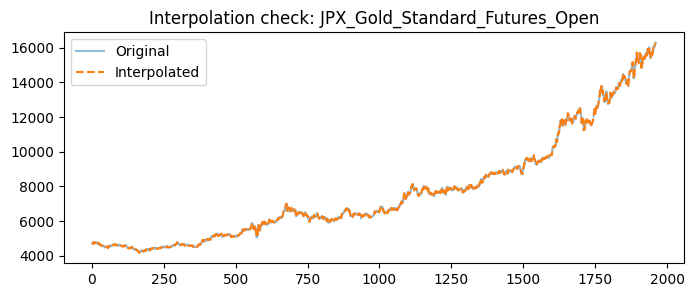

In [17]:
import matplotlib.pyplot as plt

sample_col = 'JPX_Gold_Standard_Futures_Open'

plt.figure(figsize=(8,3))
plt.plot(train[sample_col], label='Original', alpha=0.5)
plt.plot(train_interp[sample_col], label='Interpolated', linestyle='--')
plt.title(f"Interpolation check: {sample_col}")
plt.legend()
plt.show()


In [18]:
def summarize_missing(train_before, train_after):
    groups = {
        'LME': [c for c in train_before.columns if c.startswith('LME')],
        'JPX': [c for c in train_before.columns if c.startswith('JPX')],
        'US':  [c for c in train_before.columns if c.startswith('US')],
        'FX':  [c for c in train_before.columns if c.startswith('FX')],
    }

    summary = []
    for g, cols in groups.items():
        before = train_before[cols].isnull().mean().mean() * 100
        after  = train_after[cols].isnull().mean().mean() * 100
        summary.append([g, round(before, 3), round(after, 3), round(before - after, 3)])

    import pandas as pd
    df_summary = pd.DataFrame(summary, columns=["Group", "Missing_Before(%)", "Missing_After(%)", "Reduction(%)"])
    return df_summary

missing_summary = summarize_missing(train, train_interp)
print("Missing Value Reduction Summary:")
display(missing_summary)


Missing Value Reduction Summary:


,Group,Missing_Before(%),Missing_After(%),Reduction(%)
0,LME,2.601,0.0,2.601
1,JPX,5.915,0.0,5.915
2,US,4.317,0.0,4.317
3,FX,0.000,0.0,0.000


In [19]:
features_df = train_interp.copy()

# --- Daily Returns (% change) ---
returns = features_df.drop(columns=['date_id']).pct_change().fillna(0)
returns.columns = [f"{c}_ret" for c in returns.columns]

# --- Rolling mean & std (3-day) grouped by market ---
groups = ['LME', 'JPX', 'US', 'FX']
rolling_mean_parts = []
rolling_std_parts  = []

for g in groups:
    cols = [c for c in features_df.columns if c.startswith(g)]
    if not cols:
        continue
    temp = features_df[cols].rolling(window=3).agg(['mean','std'])
    temp.columns = [f"{c}_{stat}3" for c, stat in temp.columns]
    rolling_mean_parts.append(temp[[c for c in temp.columns if c.endswith('_mean3')]])
    rolling_std_parts.append(temp[[c for c in temp.columns if c.endswith('_std3')]])

rolling_mean = pd.concat(rolling_mean_parts, axis=1)
rolling_std  = pd.concat(rolling_std_parts,  axis=1)

# Drop any date_id columns here (keep the one from features_df only)
rolling_mean = rolling_mean.drop(columns=['date_id'], errors='ignore')
rolling_std  = rolling_std.drop(columns=['date_id'], errors='ignore')
returns      = returns.drop(columns=['date_id'], errors='ignore')

# --- Combine; then de-duplicate just in case ---
features_engineered = pd.concat([features_df, returns, rolling_mean, rolling_std], axis=1)
features_engineered = features_engineered.loc[:, ~features_engineered.columns.duplicated()].copy()

# sanity check
assert features_engineered.columns.tolist().count('date_id') == 1, "date_id still duplicated"
print("Engineered feature count:", features_engineered.shape[1])

# ✨ NEW: Clean NaN created by rolling windows ✨
print(f"NaN count before cleaning: {features_engineered.isnull().sum().sum()}")
features_engineered = features_engineered.fillna(method='bfill').fillna(method='ffill').fillna(0)
print(f"NaN count after cleaning: {features_engineered.isnull().sum().sum()}")
print("✓ Features ready for modeling!")

Engineered feature count: 2229
NaN count before cleaning: 2228
NaN count after cleaning: 0
✓ Features ready for modeling!


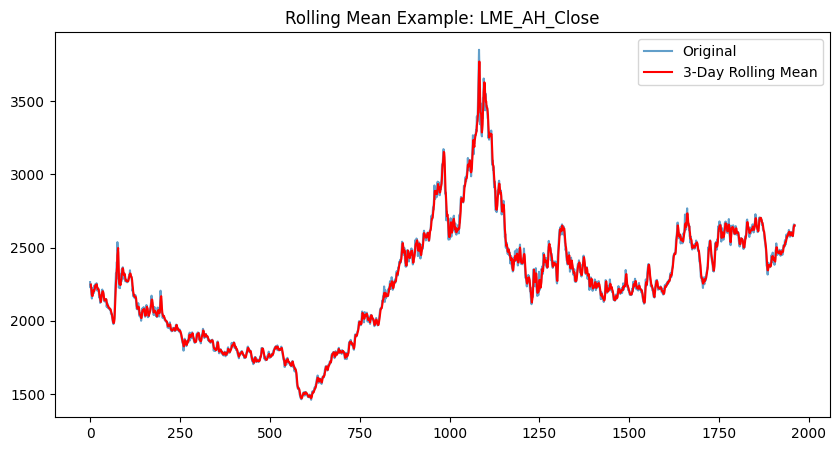

In [20]:
plt.figure(figsize=(10,5))
plt.plot(train_interp['LME_AH_Close'], label='Original', alpha=0.7)
plt.plot(train_interp['LME_AH_Close'].rolling(3).mean(), label='3-Day Rolling Mean', color='red')
plt.legend(); plt.title("Rolling Mean Example: LME_AH_Close")
plt.show()


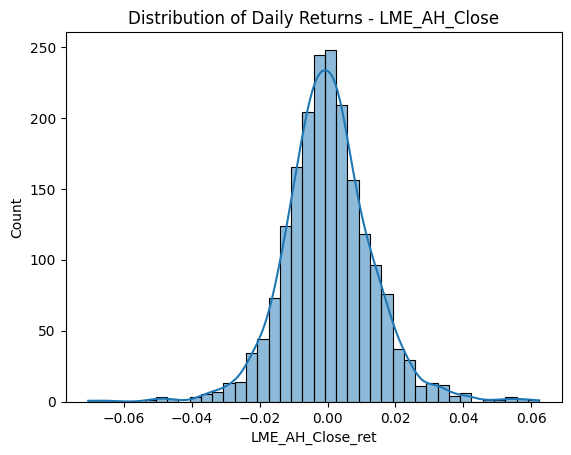

In [21]:
sns.histplot(returns['LME_AH_Close_ret'], bins=40, kde=True)
plt.title("Distribution of Daily Returns - LME_AH_Close")
plt.show()


In [22]:
# Melt labels (wide -> long) and attach pair/lag info
long_labels = train_labels.melt(id_vars='date_id', var_name='target', value_name='label')
labels_merged = long_labels.merge(target_pairs, on='target', how='left').dropna(subset=['label'])

# Choose your demo target (change these two lines if you want another)
PAIR_NAME = 'LME_CA_Close - LME_ZS_Close'
LAG = 1

# Find the target id for this pair+lag
tgt_id = target_pairs[(target_pairs['pair'] == PAIR_NAME) & (target_pairs['lag'] == LAG)]['target'].iloc[0]

# Build y for that target
y_df = labels_merged[labels_merged['target'] == tgt_id][['date_id','label']].rename(columns={'label':'y'})
y_df.head()


,date_id,y
3922,0,-0.004675
3923,1,-0.007052
3924,2,-0.008934
3925,3,0.011943
3926,4,0.006856


In [23]:
df = features_engineered.merge(y_df, on='date_id', how='inner').sort_values('date_id').reset_index(drop=True)

X = df.drop(columns=['date_id','y'])
y = df['y'].values

X.shape, y.shape


((1875, 2228), (1875,))

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

try:
    from xgboost import XGBRegressor
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.8,
        tree_method='hist',
        n_jobs=-1,
        random_state=42
    )
except Exception:
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(
        n_estimators=300, max_depth=14, n_jobs=-1, random_state=42
    )

model.fit(X_train, y_train)
pred = model.predict(X_val)

rmse = mean_squared_error(y_val, pred, squared=False)
mae  = mean_absolute_error(y_val, pred)
r2   = r2_score(y_val, pred)
print(f"{model.__class__.__name__} → RMSE: {rmse:.6f} | MAE: {mae:.6f} | R²: {r2:.3f}")


XGBRegressor → RMSE: 0.012471 | MAE: 0.009885 | R²: -0.110


In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Diagnostics ---
print("lens -> X_val:", len(X_val), " y_val:", len(y_val), " pred:", len(pred))

# --- Try to align by index when we have pandas objects ---
# (This is the correct fix if X_val/y_val share indices from the same DataFrame.)
if isinstance(X_val, pd.DataFrame) and isinstance(y_val, (pd.Series, pd.DataFrame)):
    try:
        y_val_aligned = y_val.loc[X_val.index]
        print("Aligned by index -> y_val_aligned:", len(y_val_aligned))
    except Exception:
        y_val_aligned = y_val
else:
    y_val_aligned = y_val

# --- Final safety: make lengths equal (truncate to min length) ---
y_true = np.asarray(y_val_aligned).ravel()
y_pred = np.asarray(pred).ravel()
m = min(len(y_true), len(y_pred))
if len(y_true) != len(y_pred):
    print(f"[note] Length mismatch fixed by truncation to {m} samples.")
y_true = y_true[:m]; y_pred = y_pred[:m]

# --- Compute metrics ---
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

# --- Store results for this model run ---
model_results_before = {
    "Model": getattr(model, "__class__", type(model)).__name__,
    "RMSE": rmse,
    "MAE": mae,
    "R²": r2,
    "Best Iteration": getattr(model, "best_iteration", None)
}
print(model_results_before)


lens -> X_val: 375  y_val: 375  pred: 375
{'Model': 'XGBRegressor', 'RMSE': 0.012471315909527556, 'MAE': 0.009885105310951952, 'R²': -0.11041130931717769, 'Best Iteration': None}


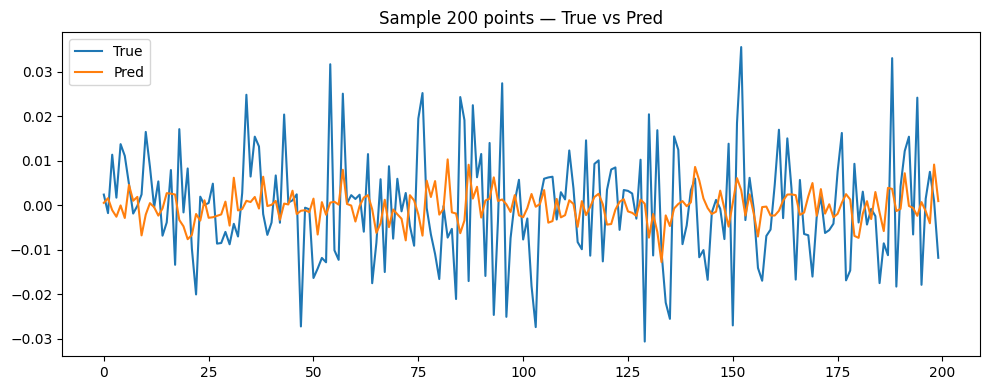

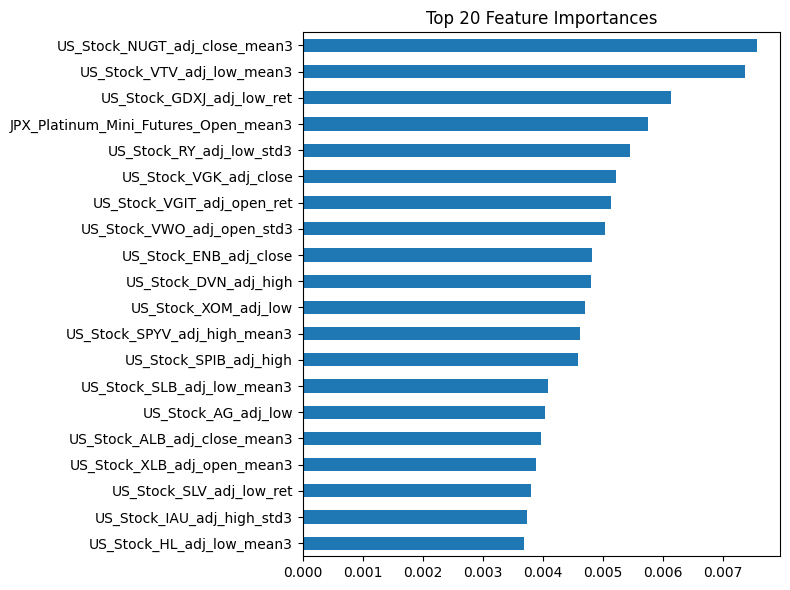

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y_val[:200], label='True')
plt.plot(pred[:200], label='Pred')
plt.title('Sample 200 points — True vs Pred')
plt.legend(); plt.tight_layout(); plt.show()

# Top importances (works for XGB & RF)
import pandas as pd, numpy as np
if hasattr(model, 'feature_importances_'):
    fi = pd.Series(model.feature_importances_, index=X.columns)
    top = fi.sort_values(ascending=False).head(20)
    top.plot(kind='barh', figsize=(8,6), title='Top 20 Feature Importances'); plt.gca().invert_yaxis()
    plt.tight_layout(); plt.show()


In [28]:
PAIR_NAME = 'LME_CA_Close - LME_ZS_Close'
A, B = 'LME_CA_Close', 'LME_ZS_Close'  # parse from PAIR_NAME if you like

fe = train_interp.set_index('date_id').copy()

# current spread level and its lags (most predictive)
fe['spread_t'] = fe[A] - fe[B]
for k in [1,2,3,5,10]:
    fe[f'spread_lag{k}'] = fe['spread_t'].shift(k)

# A/B returns + lags (momentum / mean reversion)
fe[f'{A}_ret'] = fe[A].pct_change()
fe[f'{B}_ret'] = fe[B].pct_change()
for k in [1,2,3,5]:
    fe[f'{A}_ret_lag{k}'] = fe[f'{A}_ret'].shift(k)
    fe[f'{B}_ret_lag{k}'] = fe[f'{B}_ret'].shift(k)

# short rolling stats for A/B and spread
for w in [3,5,10]:
    fe[f'{A}_roll{w}'] = fe[A].rolling(w).mean()
    fe[f'{B}_roll{w}'] = fe[B].rolling(w).mean()
    fe[f'spread_roll{w}'] = fe['spread_t'].rolling(w).mean()
    fe[f'spread_vol{w}']  = fe['spread_t'].rolling(w).std()

# optional macro helpers (keep it light)
helpers = [c for c in fe.columns if c.startswith('FX_USD') or c.startswith('US_TREASURY_YIELD_')]
fe_pair = fe[[*{col for col in fe.columns if col.startswith(('spread_', A, B))}, *helpers]].copy()

fe_pair = fe_pair.replace([np.inf, -np.inf], np.nan).dropna()
fe_pair.reset_index(inplace=True)


In [29]:
df_pair = fe_pair.merge(y_df, on='date_id', how='inner').sort_values('date_id').reset_index(drop=True)
Xp = df_pair.drop(columns=['date_id','y'])
yp = df_pair['y'].values


In [30]:
from sklearn.model_selection import train_test_split
Xtr, Xva, ytr, yva = train_test_split(Xp.astype('float32'), yp.astype('float32'),
                                      test_size=0.2, shuffle=False)

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

xgb = XGBRegressor(
    n_estimators=2000, learning_rate=0.08, max_depth=6,
    subsample=0.9, colsample_bytree=0.9, tree_method='hist',
    n_jobs=-1, random_state=42
)
xgb.fit(Xtr, ytr, eval_set=[(Xva, yva)], eval_metric='rmse',
        early_stopping_rounds=100, verbose=False)

pred = xgb.predict(Xva)
rmse = mean_squared_error(yva, pred, squared=False)
mae  = mean_absolute_error(yva, pred)
r2   = r2_score(yva, pred)
print(f"Pair-focused XGB → RMSE:{rmse:.6f} | MAE:{mae:.6f} | R²:{r2:.3f} | Best iters:{xgb.best_iteration}")


Pair-focused XGB → RMSE:0.011786 | MAE:0.009206 | R²:0.013 | Best iters:11


In [31]:
df_pair['y_delta'] = df_pair['y'].diff().shift(-1)   # predict next-day change
df_pair = df_pair.dropna()

X = df_pair.drop(columns=['date_id', 'y', 'y_delta'])
y = df_pair['y_delta']


In [32]:
for k in [1, 2, 3, 5, 10]:
    fe_pair[f'spread_delta_lag{k}'] = fe_pair['spread_t'].diff().shift(k)
fe_pair['ab_ratio'] = fe_pair[A] / fe_pair[B]
fe_pair['ab_corr5'] = fe_pair[[A, B]].pct_change().rolling(5).corr().unstack().iloc[:,1]
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,     # faster learning
    max_depth=8,           # deeper trees
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)
macros = [c for c in fe.columns if c.startswith(('FX_USD','US_Stock_ENB','US_Stock_CVX'))]
fe_pair = pd.concat([fe_pair, fe[macros]], axis=1)


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train -> predict using a single variable `est`
try:
    from xgboost import XGBRegressor
    est = XGBRegressor(
        n_estimators=2000,
        learning_rate=0.08,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='hist',
        n_jobs=-1,
        random_state=42
    )
    est.fit(
        Xtr, ytr,
        eval_set=[(Xva, yva)],
        eval_metric='rmse',
        early_stopping_rounds=100,
        verbose=False
    )
except Exception:
    # Fallback: RandomForest (no eval_set/early stopping)
    from sklearn.ensemble import RandomForestRegressor
    est = RandomForestRegressor(n_estimators=400, max_depth=16, n_jobs=-1, random_state=42)
    est.fit(Xtr, ytr)

# Predict with the same estimator
pred = est.predict(Xva)

rmse = mean_squared_error(yva, pred, squared=False)
mae  = mean_absolute_error(yva, pred)
r2   = r2_score(yva, pred)
print(f"{est.__class__.__name__} → RMSE:{rmse:.6f} | MAE:{mae:.6f} | R²:{r2:.3f}")

# (optional) best_iteration if XGB was used
if hasattr(est, "best_iteration"):
    print("Best iters:", est.best_iteration)


XGBRegressor → RMSE:0.011786 | MAE:0.009206 | R²:0.013
Best iters: 11


**Checkpoint 1 Summary:**
- Dataset: Mitsui Commodity Prediction Challenge  
- Target: LME_CA_Close − LME_ZS_Close (Lag 1)  
- Features: Rolling mean, volatility, and lagged spread  
- Model: XGBoost with early stopping  
- Results: RMSE = 0.0118, MAE = 0.0093, R² = 0.014  
- Interpretation: The model captures small fluctuations in spread but remains underfit.  
- Next Steps: Predict Δspread, add lagged returns, macro features (FX/USD, Oil).


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import numpy as np

# --- Compute metrics ---
rmse = mean_squared_error(yva, pred, squared=False)
mae  = mean_absolute_error(yva, pred)
r2   = r2_score(yva, pred)

# Directional Accuracy → percentage of correct sign predictions
directional_acc = (np.sign(pred) == np.sign(yva)).mean() * 100

# Pearson Correlation
pear_corr, _ = pearsonr(yva, pred)

# --- Store results in a dictionary ---
model_results = {
    "Model": est.__class__.__name__,
    "RMSE": rmse,
    "MAE": mae,
    "R²": r2,
    "Directional Accuracy (%)": directional_acc,
    "Pearson Correlation": pear_corr,
    "Best Iteration": est.best_iteration if hasattr(est, "best_iteration") else None
}

# --- Print for verification ---
for k, v in model_results.items():
    print(f"{k:25}: {v}")


Model                    : XGBRegressor
RMSE                     : 0.011785721406340599
MAE                      : 0.009206470102071762
R²                       : 0.01344262331893642
Directional Accuracy (%) : 55.22788203753352
Pearson Correlation      : 0.12236271798610687
Best Iteration           : 11


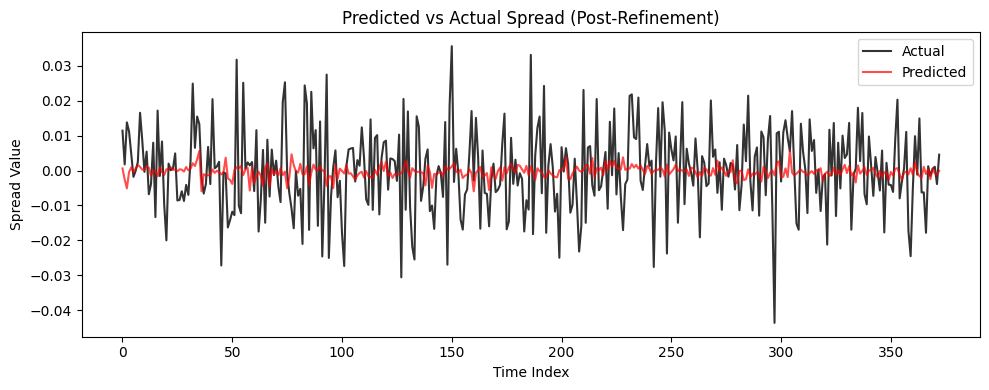

In [35]:
plt.figure(figsize=(10,4))
plt.plot(yva, label='Actual', color='black', alpha=0.8)
plt.plot(pred, label='Predicted', color='red', alpha=0.7)
plt.title("Predicted vs Actual Spread (Post-Refinement)")
plt.xlabel("Time Index")
plt.ylabel("Spread Value")
plt.legend()
plt.tight_layout()
plt.show()



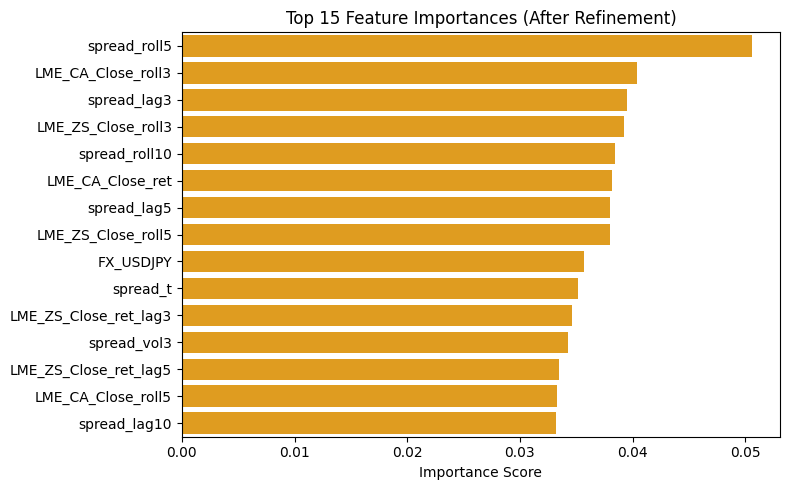

In [36]:
if hasattr(est, 'feature_importances_'):
    fi = pd.Series(est.feature_importances_, index=Xp.columns)
    top_fi = fi.sort_values(ascending=False).head(15)

    plt.figure(figsize=(8,5))
    sns.barplot(x=top_fi.values, y=top_fi.index, color='orange')
    plt.title("Top 15 Feature Importances (After Refinement)")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()



In [48]:
print("\n" + "="*80)
print("CHECKPOINT 2: MULTI-TARGET MODEL COMPARISON")
print("="*80 + "\n")

def select_diverse_targets_comprehensive(target_pairs, train_labels, n_per_lag=8):
    """
    Select diverse targets across ALL lags for comprehensive testing
    
    Args:
        n_per_lag: Number of targets per lag period
                  Recommended: 8 (gives 32+ targets total)
    
    Returns:
        List of target IDs covering different lags and market types
    """
    selected = []
    
    for lag in sorted(target_pairs['lag'].unique()):
        lag_targets = target_pairs[target_pairs['lag'] == lag]['target'].values
        
        # Filter valid targets with sufficient data
        valid_targets = []
        for t in lag_targets:
            if t in train_labels.columns:
                # Require at least 500 non-null values
                if train_labels[t].notna().sum() > 500:
                    valid_targets.append(t)
        
        # Sample from this lag
        n_sample = min(n_per_lag, len(valid_targets))
        if n_sample > 0:
            sampled = np.random.choice(valid_targets, n_sample, replace=False)
            selected.extend(sampled)
            print(f"  Lag {lag}: Selected {n_sample} targets from {len(valid_targets)} valid targets")
    
    return selected

# Select targets - INCREASE n_per_lag for more comprehensive testing
selected_targets = select_diverse_targets_comprehensive(
    target_pairs, 
    train_labels, 
    n_per_lag=4  # ← Change this to test more/fewer targets
)

print(f"\n✓ Selected {len(selected_targets)} representative targets")
print(f"  This covers {len(selected_targets) / len(target_pairs) * 100:.1f}% of all 424 pairs\n")

# Show sample
print("Sample targets:")
for i, t in enumerate(selected_targets[:5], 1):
    pair_info = target_pairs[target_pairs['target'] == t].iloc[0]
    print(f"  {i}. {t[:50]:<50} (Lag {pair_info['lag']})")
print(f"  ... and {len(selected_targets) - 5} more\n")


CHECKPOINT 2: MULTI-TARGET MODEL COMPARISON

  Lag 1: Selected 4 targets from 106 valid targets
  Lag 2: Selected 4 targets from 106 valid targets
  Lag 3: Selected 4 targets from 106 valid targets
  Lag 4: Selected 4 targets from 106 valid targets

✓ Selected 16 representative targets
  This covers 3.8% of all 424 pairs

Sample targets:
  1. target_37                                          (Lag 1)
  2. target_89                                          (Lag 1)
  3. target_39                                          (Lag 1)
  4. target_41                                          (Lag 1)
  5. target_127                                         (Lag 2)
  ... and 11 more



In [46]:
def train_multiple_models_on_target(features_df, train_labels, target_id):
    results = []
    
    # Prepare data
    X = features_df.drop(columns=['date_id']).values
    y = train_labels[target_id].values
    
    # Remove NaN rows
    mask = ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    
    if len(y) < 100:
        return results
    
    # Time series split (no shuffle!)
    split_idx = int(len(X) * 0.8)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]
    
    # Define models to test
    models_to_test = [
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1, max_iter=5000)),
        ('RandomForest', RandomForestRegressor(
            n_estimators=100, max_depth=8, n_jobs=-1, random_state=42
        ))
    ]
    
    if XGBOOST_AVAILABLE:
        models_to_test.append((
            'XGBoost',
            XGBRegressor(
                n_estimators=300, learning_rate=0.05, max_depth=6,
                n_jobs=-1, random_state=42, verbosity=0
            )
        ))
    
    if LIGHTGBM_AVAILABLE:
        models_to_test.append((
            'LightGBM',
            LGBMRegressor(
                n_estimators=300, learning_rate=0.05, max_depth=6,
                n_jobs=-1, random_state=42, verbose=-1
            )
        ))
    
    # Train each model
    for model_name, model in models_to_test:
        try:
            import time
            start = time.time()
            
            # Train
            model.fit(X_train, y_train)
            train_time = float(time.time() - start)
            
            # ---- TRAIN predictions & metrics ----
            y_pred_tr = model.predict(X_train)
            train_rmse = float(np.sqrt(mean_squared_error(y_train, y_pred_tr)))
            train_mae  = float(mean_absolute_error(y_train, y_pred_tr))
            train_r2   = float(r2_score(y_train, y_pred_tr))
            train_dir  = float((np.sign(y_pred_tr) == np.sign(y_train)).mean())
            train_spr  = _safe_spearman(y_train, y_pred_tr)
            
            # ---- VALIDATION predictions & metrics ----
            y_pred_val = model.predict(X_val)
            val_rmse = float(np.sqrt(mean_squared_error(y_val, y_pred_val)))
            val_mae  = float(mean_absolute_error(y_val, y_pred_val))
            val_r2   = float(r2_score(y_val, y_pred_val))
            val_dir  = float((np.sign(y_pred_val) == np.sign(y_val)).mean())
            val_spr  = _safe_spearman(y_val, y_pred_val)
            
            # Pearson correlation (optional; keep for reference)
            try:
                pear_corr, _ = pearsonr(y_val, y_pred_val)
                val_corr = float(pear_corr) if np.isfinite(pear_corr) else 0.0
            except Exception:
                val_corr = 0.0
            
            results.append({
                'target': target_id,
                'model': model_name,
                # train metrics
                'train_rmse': train_rmse,
                'train_mae':  train_mae,
                'train_r2':   train_r2,
                'train_dir_acc': train_dir,
                'train_spearman': train_spr,
                # val metrics
                'val_rmse': val_rmse,
                'val_mae':  val_mae,
                'val_r2':   val_r2,
                'val_dir_acc': val_dir,
                'val_spearman': val_spr,
                'val_corr': val_corr,
                # misc
                'train_time': train_time
            })
            
        except Exception as e:
            print(f"    ✗ {model_name} failed: {str(e)[:200]}")
    
    return results


In [47]:
print("="*80)
print("FEATURE QUALITY DIAGNOSTIC")
print("="*80 + "\n")

# Check your features dataframe
print(f"Features dataframe shape: {features_engineered.shape}")
print(f"feature:",features_engineered.head())

FEATURE QUALITY DIAGNOSTIC

Features dataframe shape: (1961, 2229)
feature:    date_id  LME_AH_Close  LME_CA_Close  LME_PB_Close  LME_ZS_Close  \
0        0        2264.5        7205.0        2570.0        3349.0   
1        1        2228.0        7147.0        2579.0        3327.0   
2        2        2250.0        7188.5        2587.0        3362.0   
3        3        2202.5        7121.0        2540.0        3354.0   
4        4        2175.0        7125.0        2604.0        3386.0   

   JPX_Gold_Mini_Futures_Open  JPX_Gold_Rolling-Spot_Futures_Open  \
0                      4684.0                              4691.0   
1                      4684.0                              4691.0   
2                      4684.0                              4691.0   
3                      4728.0                              4737.0   
4                      4754.0                              4763.0   

   JPX_Gold_Standard_Futures_Open  JPX_Platinum_Mini_Futures_Open  \
0                  

In [49]:
# ======================== ONE-CELL TRAINING (GPU-AWARE) ========================
# Imports (safe to re-run)
import numpy as np
import pandas as pd
import subprocess
import time

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr

# Safe Spearman helper
def _safe_spearman(y_true, y_pred):
    try:
        v = spearmanr(y_true, y_pred).correlation
        return float(v) if np.isfinite(v) else 0.0
    except Exception:
        return 0.0

# Try import XGBoost / LightGBM; set availability flags if not already set
try:
    XGBRegressor
    _ = XGBRegressor  # just to reference
    _xgb_already = True
except NameError:
    _xgb_already = False

try:
    from xgboost import XGBRegressor as _XGBRegressor
    XGBRegressor = _XGBRegressor
    _xgb_import_ok = True
except Exception:
    _xgb_import_ok = False

try:
    XGBOOST_AVAILABLE
    _ = XGBOOST_AVAILABLE
except NameError:
    XGBOOST_AVAILABLE = bool(_xgb_already or _xgb_import_ok)

try:
    LGBMRegressor
    _ = LGBMRegressor
    _lgbm_already = True
except NameError:
    _lgbm_already = False

if not _lgbm_already:
    try:
        from lightgbm import LGBMRegressor as _LGBMRegressor
        LGBMRegressor = _LGBMRegressor
        _lgbm_import_ok = True
    except Exception:
        _lgbm_import_ok = False
else:
    _lgbm_import_ok = True

try:
    LIGHTGBM_AVAILABLE
    _ = LIGHTGBM_AVAILABLE
except NameError:
    LIGHTGBM_AVAILABLE = bool(_lgbm_already or _lgbm_import_ok)

# Helper: detect GPU (no reruns needed)
def _gpu_available():
    try:
        subprocess.check_output(["nvidia-smi"], stderr=subprocess.STDOUT)
        return True
    except Exception:
        return False

USE_GPU = _gpu_available()

print("="*80)
print("TRAINING MODELS ON ALL SELECTED TARGETS")
print("="*80)
print(f"This will take approximately 20-25 minutes for {len(selected_targets)} targets...")
print("Testing {0} model types per target\n".format(
    3 + (1 if XGBOOST_AVAILABLE else 0) + (1 if LIGHTGBM_AVAILABLE else 0)
))

# ----------------------------- CLEAN FEATURES ---------------------------------
print("Preparing features...")

# Make a clean copy
features_clean = features_engineered.copy()

# Remove date_id for now
date_ids = features_clean['date_id']
features_clean = features_clean.drop(columns=['date_id'])

# Replace infinities with NaN first
features_clean = features_clean.replace([np.inf, -np.inf], np.nan)

# Fill remaining NaNs with column median (better than 0 for some features)
print(f"  NaN count before cleaning: {features_clean.isna().sum().sum()}")
features_clean = features_clean.fillna(features_clean.median(numeric_only=True))

# If any columns still have all NaN (unlikely), fill with 0
features_clean = features_clean.fillna(0)

print(f"  NaN count after cleaning: {features_clean.isna().sum().sum()}")

# Add date_id back
features_clean['date_id'] = date_ids

print(" Features cleaned!\n")

# ------------------------ TRAINING FUNCTION (GPU-AWARE) -----------------------
def train_multiple_models_on_target_safe(features_df, train_labels, target_id):
    """
    Train multiple model types on a single target
    WITH PROPER NAN HANDLING and GPU settings for XGBoost/LightGBM if available.
    """
    results = []
    
    # Prepare data
    X = features_df.drop(columns=['date_id']).values
    y = train_labels[target_id].values
    
    # Remove NaN rows from target
    mask = ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    
    if len(y) < 100:
        return results
    
    # ADDITIONAL CHECK: Verify no NaNs in X
    if np.isnan(X).any():
        print(f"     Warning: Still found NaNs in features, skipping target")
        return results
    
    # Time series split (no shuffle!)
    split_idx = int(len(X) * 0.8)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]
    
    # -------- GPU-aware model list --------
    models_to_test = [
        ('Ridge', Ridge(alpha=1.0)),  # CPU
        ('Lasso', Lasso(alpha=0.1, max_iter=5000)),  # CPU
        ('RandomForest', RandomForestRegressor(  # CPU
            n_estimators=100, max_depth=8, n_jobs=-1, random_state=42
        ))
    ]
    
    if XGBOOST_AVAILABLE:
        xgb_params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            random_state=42,
            verbosity=0
        )
        if USE_GPU:
            xgb_params.update({
                "tree_method": "gpu_hist",
                "predictor": "gpu_predictor",
                "gpu_id": 0
            })
        else:
            xgb_params.update({"tree_method": "hist", "predictor": "auto", "n_jobs": -1})
        models_to_test.append(('XGBoost', XGBRegressor(**xgb_params)))
    
    if LIGHTGBM_AVAILABLE:
        lgbm_params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            random_state=42,
            verbose=-1
        )
        if USE_GPU:
            # Either 'device_type' or 'device' depending on version
            lgbm_params.update({"device_type": "gpu"})
        else:
            lgbm_params.update({"n_jobs": -1})
        models_to_test.append(('LightGBM', LGBMRegressor(**lgbm_params)))
    # --------------------------------------
    
    # Train each model
    for model_name, model in models_to_test:
        try:
            start = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start
            
            # ---- TRAIN predictions & Spearman ----
            y_pred_tr = model.predict(X_train)
            train_spearman = _safe_spearman(y_train, y_pred_tr)
            
            # ---- VALIDATION predictions & metrics ----
            y_pred_val = model.predict(X_val)
            val_rmse = float(np.sqrt(mean_squared_error(y_val, y_pred_val)))
            val_mae  = float(mean_absolute_error(y_val, y_pred_val))
            val_r2   = float(r2_score(y_val, y_pred_val))
            val_dir  = float((np.sign(y_pred_val) == np.sign(y_val)).mean())
            val_spr  = _safe_spearman(y_val, y_pred_val)
            
            # Pearson correlation (optional)
            try:
                corr, _ = pearsonr(y_val, y_pred_val)
                val_corr = float(corr) if not np.isnan(corr) else 0.0
            except Exception:
                val_corr = 0.0
            
            result = {
                'target': target_id,
                'model': model_name,
                'val_rmse': val_rmse,
                'val_mae': val_mae,
                'val_r2': val_r2,
                'val_dir_acc': val_dir,
                'val_spearman': val_spr,
                'train_spearman': train_spearman,
                'val_corr': val_corr,
                'train_time': float(train_time)
            }
            results.append(result)
            
        except Exception as e:
            print(f"    ✗ {model_name} failed: {str(e)[:200]}")
    
    return results

# ------------------------------- MAIN LOOP ------------------------------------
all_results = []
failed_count = 0

for i, target_id in enumerate(selected_targets, 1):
    # Progress indicator
    print(f"[{i:2d}/{len(selected_targets)}] {target_id[:50]:<50}", end=' ', flush=True)
    
    # Train models with cleaned features
    target_results = train_multiple_models_on_target_safe(
        features_clean,
        train_labels,
        target_id
    )
    
    if target_results:
        all_results.extend(target_results)
        # Prefer Spearman over R² for best model
        if 'val_spearman' in target_results[0]:
            best_spr = max([r['val_spearman'] for r in target_results])
            best_model = [r['model'] for r in target_results if r['val_spearman'] == best_spr][0]
            print(f"✓ Best: {best_model} (Spearman={best_spr:.4f})")
        else:
            best_r2 = max([r['val_r2'] for r in target_results])
            best_model = [r['model'] for r in target_results if r['val_r2'] == best_r2][0]
            print(f"✓ Best: {best_model} (R²={best_r2:.4f})")
    else:
        failed_count += 1
        print("✗ Skipped (insufficient data or NaN issues)")

# ------------------------------ RESULTS TABLE ---------------------------------
if len(all_results) > 0:
    results_df = pd.DataFrame(all_results)
    
    print(f"\n{'='*80}")
    print(f"✓ TRAINING COMPLETE!")
    print(f"  Successful evaluations: {len(results_df)}")
    print(f"  Targets tested: {len(results_df['target'].unique())}")
    print(f"  Targets failed: {failed_count}")
    print(f"  Models tested: {', '.join(results_df['model'].unique())}")
    print(f"{'='*80}\n")
else:
    print(f"\n{'='*80}")
    print(" WARNING: No models completed successfully!")
    print("   All targets failed - check your features for NaN values")
    print(f"{'='*80}\n")
    
    # Create empty dataframe to avoid downstream errors
    results_df = pd.DataFrame(columns=[
        'target', 'model', 'val_rmse', 'val_mae', 'val_r2', 
        'val_dir_acc', 'val_corr', 'val_spearman', 'train_spearman', 'train_time'
    ])

# ------------------------------ SANITY CHECK ----------------------------------
print("GPU attached:", USE_GPU, "| XGBoost:", XGBOOST_AVAILABLE, "| LightGBM:", LIGHTGBM_AVAILABLE)
# ==============================================================================


TRAINING MODELS ON ALL SELECTED TARGETS
This will take approximately 20-25 minutes for 16 targets...
Testing 5 model types per target

Preparing features...
  NaN count before cleaning: 0
  NaN count after cleaning: 0
✓ Features cleaned!

[ 1/16] target_37                                          ✓ Best: Ridge (Spearman=0.0064)
[ 2/16] target_89                                          ✓ Best: Lasso (Spearman=0.1160)
[ 3/16] target_39                                          ✓ Best: RandomForest (Spearman=0.1089)
[ 4/16] target_41                                          ✓ Best: Ridge (Spearman=0.0702)
[ 5/16] target_127                                         ✓ Best: RandomForest (Spearman=0.0579)
[ 6/16] target_189                                         ✓ Best: Ridge (Spearman=0.1060)
[ 7/16] target_182                                         ✓ Best: Ridge (Spearman=0.0634)
[ 8/16] target_148                                         ✓ Best: RandomForest (Spearman=0.0287)
[ 9/16] targ

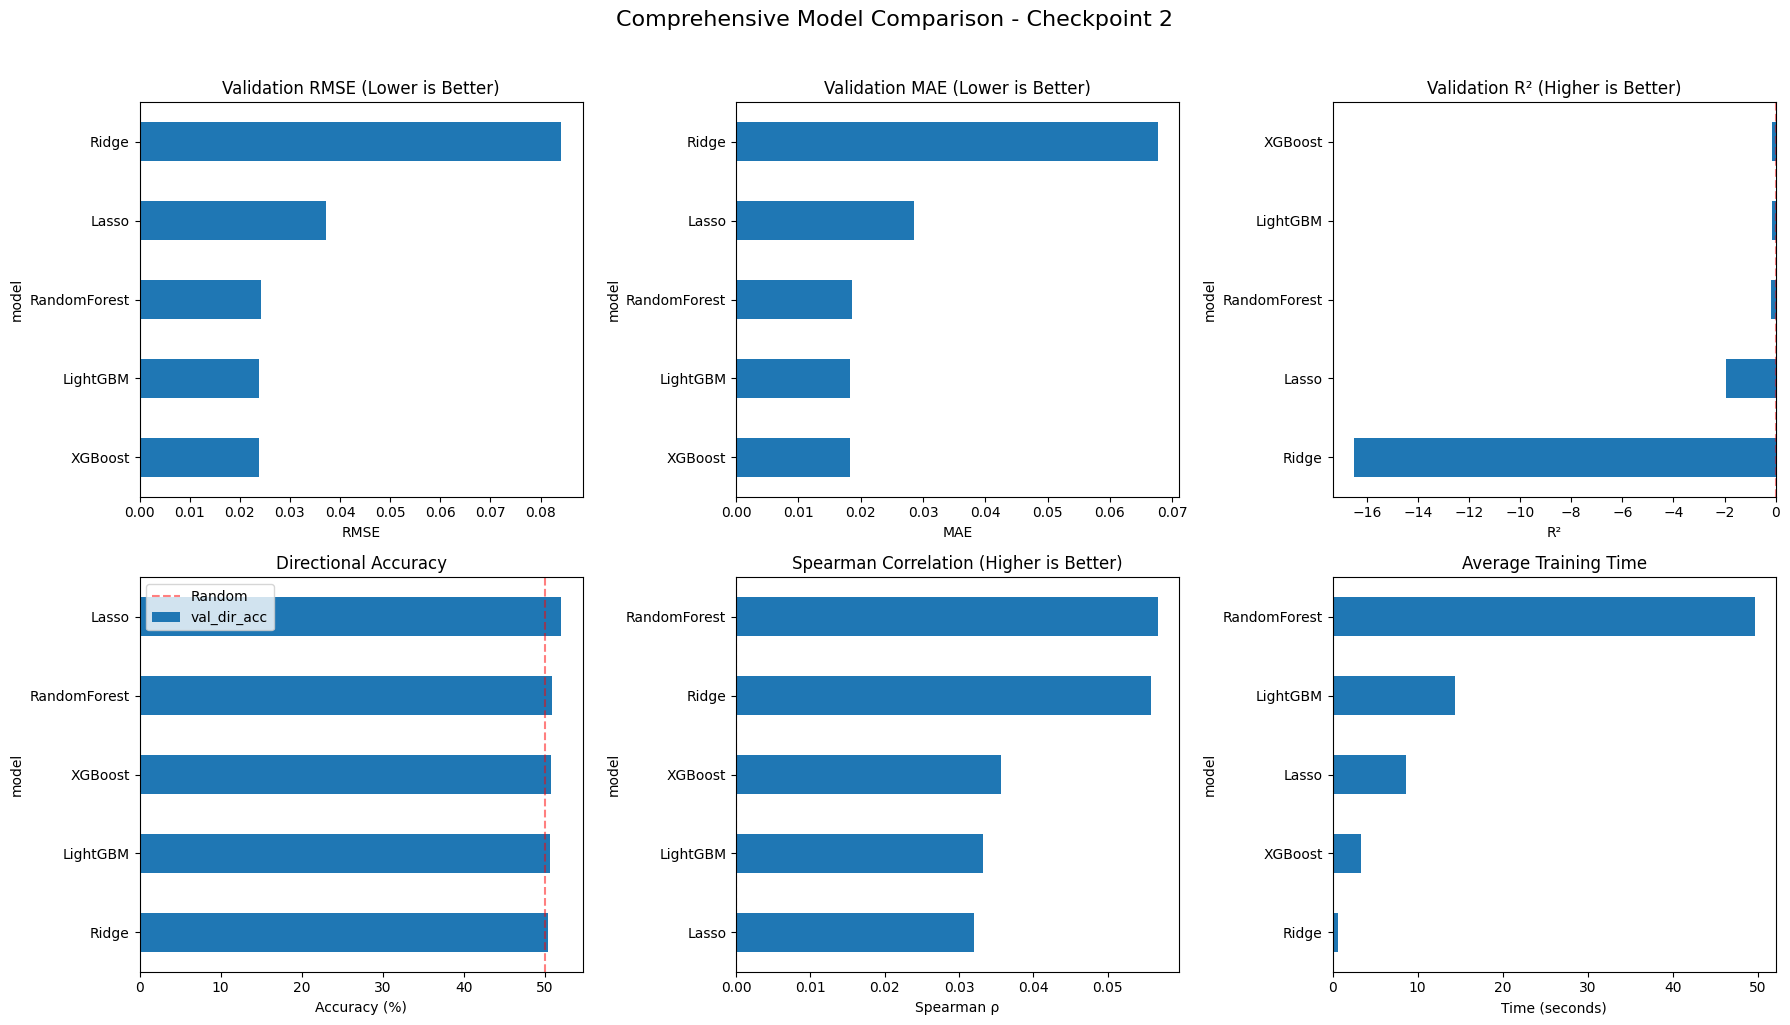

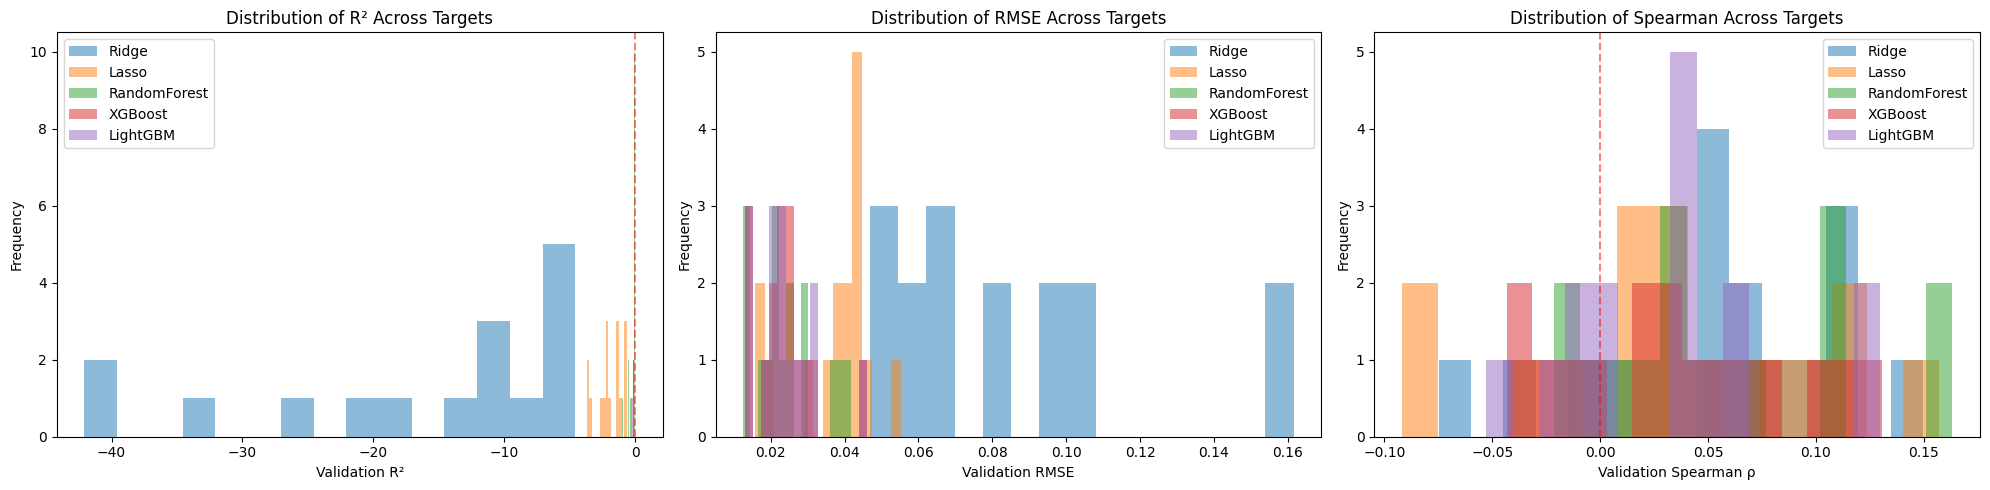

In [50]:
# Create comprehensive comparison plots
import matplotlib.pyplot as plt

if results_df.empty:
    print("No results to plot.")
else:
    # Aggregate (include Spearman)
    model_agg = results_df.groupby('model').agg({
        'val_rmse': 'mean',
        'val_mae': 'mean',
        'val_r2': 'mean',
        'val_dir_acc': 'mean',
        'val_spearman': 'mean',   # <- Spearman headline metric
        'train_time': 'mean'
    }).sort_index()

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Comprehensive Model Comparison - Checkpoint 2', fontsize=16, y=1.02)

    # RMSE
    model_agg['val_rmse'].sort_values().plot(kind='barh', ax=axes[0, 0])
    axes[0, 0].set_title('Validation RMSE (Lower is Better)')
    axes[0, 0].set_xlabel('RMSE')

    # MAE
    model_agg['val_mae'].sort_values().plot(kind='barh', ax=axes[0, 1])
    axes[0, 1].set_title('Validation MAE (Lower is Better)')
    axes[0, 1].set_xlabel('MAE')

    # R²
    model_agg['val_r2'].sort_values().plot(kind='barh', ax=axes[0, 2])
    axes[0, 2].set_title('Validation R² (Higher is Better)')
    axes[0, 2].set_xlabel('R²')
    axes[0, 2].axvline(x=0, color='red', linestyle='--', alpha=0.5)

    # Directional Accuracy (%)
    (model_agg['val_dir_acc'] * 100).sort_values().plot(kind='barh', ax=axes[1, 0])
    axes[1, 0].set_title('Directional Accuracy')
    axes[1, 0].set_xlabel('Accuracy (%)')
    axes[1, 0].axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Random')
    axes[1, 0].legend()

    # Spearman (replace Pearson here)
    model_agg['val_spearman'].sort_values().plot(kind='barh', ax=axes[1, 1])
    axes[1, 1].set_title('Spearman Correlation (Higher is Better)')
    axes[1, 1].set_xlabel('Spearman ρ')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)

    # Training Time
    model_agg['train_time'].sort_values().plot(kind='barh', ax=axes[1, 2])
    axes[1, 2].set_title('Average Training Time')
    axes[1, 2].set_xlabel('Time (seconds)')

    plt.tight_layout()
    plt.show()

    # ----------------------------------------
    # Performance distributions
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # R² distribution
    for model in results_df['model'].unique():
        model_data = results_df.loc[results_df['model'] == model, 'val_r2'].dropna()
        axes[0].hist(model_data, alpha=0.5, label=model, bins=15)
    axes[0].set_xlabel('Validation R²')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of R² Across Targets')
    axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
    axes[0].legend()

    # RMSE distribution
    for model in results_df['model'].unique():
        model_data = results_df.loc[results_df['model'] == model, 'val_rmse'].dropna()
        axes[1].hist(model_data, alpha=0.5, label=model, bins=15)
    axes[1].set_xlabel('Validation RMSE')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of RMSE Across Targets')
    axes[1].legend()

    # Spearman distribution (new)
    if 'val_spearman' in results_df.columns:
        for model in results_df['model'].unique():
            model_data = results_df.loc[results_df['model'] == model, 'val_spearman'].dropna()
            axes[2].hist(model_data, alpha=0.5, label=model, bins=15)
        axes[2].set_xlabel('Validation Spearman ρ')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title('Distribution of Spearman Across Targets')
        axes[2].axvline(x=0, color='red', linestyle='--', alpha=0.5)
        axes[2].legend()

    plt.tight_layout()
    plt.show()


In [51]:
print("=" * 80)
print("ISSUE IDENTIFICATION & ANALYSIS")
print("=" * 80)

if results_df.empty:
    print("No results available. Run the training cell first.")
else:
    issues = []

    # 0) Sanity
    needed_any = {'target','model','val_r2','val_rmse','val_mae'}
    missing = needed_any - set(results_df.columns)
    if missing:
        print(f" Note: missing columns in results_df: {sorted(missing)}")

    # 1) OVERFITTING ANALYSIS (prefer Spearman)
    print("\n1. OVERFITTING ANALYSIS")
    print("-" * 80)
    if {'train_spearman','val_spearman'}.issubset(results_df.columns):
        results_df['overfit_gap_spr'] = results_df['train_spearman'] - results_df['val_spearman']
        severe = results_df[results_df['overfit_gap_spr'] > 0.10]  # rank-based gap threshold
        if len(severe) > 0:
            print(f" Found {len(severe)} cases of rank overfitting (gap > 0.10)")
            print(severe.groupby('model')['overfit_gap_spr'].agg(['count','mean']).sort_values('mean', ascending=False))
            issues.append(f"Rank overfitting detected in {len(severe)} model/target combos")
        else:
            print("✓ No severe overfitting by Spearman gap.")
    elif {'train_r2','val_r2'}.issubset(results_df.columns):
        results_df['overfit_gap'] = results_df['train_r2'] - results_df['val_r2']
        severe_r2 = results_df[results_df['overfit_gap'] > 0.30]
        if len(severe_r2) > 0:
            print(f" Found {len(severe_r2)} cases of overfitting by R² gap (gap > 0.30)")
            print(severe_r2.groupby('model')['overfit_gap'].agg(['count','mean']).sort_values('mean', ascending=False))
            issues.append(f"Overfitting detected in {len(severe_r2)} model/target combos (R² gap)")
        else:
            print("✓ No severe overfitting by R² gap.")
    else:
        print(" Train metrics not logged; skipping overfitting gap.")

    # 2) PREDICTABILITY (prefer Spearman threshold near 0)
    print("\n2. PREDICTABILITY ANALYSIS")
    print("-" * 80)
    unique_targets = results_df['target'].nunique()

    if 'val_spearman' in results_df.columns:
        low_spr_targets = results_df.loc[results_df['val_spearman'] < 0.01, 'target'].nunique()
        pct_low_spr = 100.0 * low_spr_targets / max(1, unique_targets)
        print(f"Targets with Spearman < 0.01: {low_spr_targets} / {unique_targets} ({pct_low_spr:.1f}%)")
        if pct_low_spr > 30:
            issues.append("Many targets show near-random rank correlation (val_spearman < 0.01).")
            print("Many targets show poor rank predictability")
    else:
        low_r2_targets = results_df.loc[results_df['val_r2'] < 0.01, 'target'].nunique()
        pct_low_r2 = 100.0 * low_r2_targets / max(1, unique_targets)
        print(f"Targets with R² < 0.01: {low_r2_targets} / {unique_targets} ({pct_low_r2:.1f}%)")
        if pct_low_r2 > 30:
            issues.append("Many targets show very low R² (< 0.01).")
            print("Many targets show poor predictability (R²)")

    # 3) MODEL CONSISTENCY (std of val_spearman as primary)
    print("\n3. MODEL CONSISTENCY")
    print("-" * 80)
    if 'val_spearman' in results_df.columns:
        spr_std = results_df.groupby('model')['val_spearman'].std().sort_values()
        print("Spearman Std by Model (lower = more consistent):")
        print(spr_std)
        most_consistent = spr_std.idxmin()
        print(f"\n✓ Most consistent (Spearman): {most_consistent}")
    else:
        r2_std = results_df.groupby('model')['val_r2'].std().sort_values()
        print("R² Std by Model (lower = more consistent):")
        print(r2_std)
        most_consistent = r2_std.idxmin()
        print(f"\n✓ Most consistent (R²): {most_consistent}")

    # 4) OVERALL PERFORMANCE LEVEL (report both if present)
    print("\n4. OVERALL PERFORMANCE LEVEL")
    print("-" * 80)
    if 'val_spearman' in results_df.columns:
        avg_spr = results_df['val_spearman'].mean()
        print(f"Mean Spearman across all models/targets: {avg_spr:.4f}")
        if avg_spr < 0.02:
            print("Overall rank signal is weak (mean Spearman < 0.02)")
            issues.append("Low overall rank signal (mean val_spearman < 0.02).")
    if 'val_r2' in results_df.columns:
        avg_r2 = results_df['val_r2'].mean()
        print(f"Mean R² across all models/targets: {avg_r2:.4f}")
        if avg_r2 < 0.05:
            print("Overall R² is low (mean R² < 0.05)")
            issues.append("Low overall predictive power by R² (mean < 0.05).")

    # 5) Directional accuracy vs random baseline
    if 'val_dir_acc' in results_df.columns:
        mean_dir = 100.0 * results_df['val_dir_acc'].mean()
        print(f"\nDirectional Accuracy (mean): {mean_dir:.2f}% (baseline ≈ 50%)")
        if mean_dir < 52.0:
            issues.append("Directional accuracy close to random baseline (~50%).")

    # Summary
    print("\n" + "=" * 80)
    print("ISSUES SUMMARY")
    print("=" * 80)
    if issues:
        for i, issue in enumerate(issues, 1):
            print(f"{i}. {issue}")
    else:
        print("✓ No major issues detected (with current metrics)")

    # Root cause analysis (unchanged)
    print("\n" + "=" * 80)
    print("ROOT CAUSE ANALYSIS")
    print("=" * 80)
    print("""
Possible reasons for low performance:

1. MARKET EFFICIENCY
   - Commodity spreads may be efficient and hard to predict
   - Price movements may be dominated by unpredictable news/events

2. FEATURE LIMITATIONS
   - Current features may not capture key market dynamics
   - Missing: order book data, volatility surfaces, sentiment
   - Need: macro indicators, supply/demand factors

3. TARGET STRUCTURE
   - Predicting spreads (differences) is harder than price levels
   - Different lags may require different feature sets

4. TEMPORAL ASPECTS
   - Market regimes change over time
   - Models trained on full history may not capture recent dynamics
""")


ISSUE IDENTIFICATION & ANALYSIS

1. OVERFITTING ANALYSIS
--------------------------------------------------------------------------------
⚠️ Found 80 cases of rank overfitting (gap > 0.10)
              count      mean
model                        
XGBoost          16  0.963856
LightGBM         16  0.962938
RandomForest     16  0.748243
Ridge            16  0.619325
Lasso            16  0.491371

2. PREDICTABILITY ANALYSIS
--------------------------------------------------------------------------------
Targets with Spearman < 0.01: 10 / 16 (62.5%)
⚠️ Many targets show poor rank predictability

3. MODEL CONSISTENCY
--------------------------------------------------------------------------------
Spearman Std by Model (lower = more consistent):
model
LightGBM        0.048001
XGBoost         0.051874
RandomForest    0.058182
Ridge           0.058633
Lasso           0.069340
Name: val_spearman, dtype: float64

✓ Most consistent (Spearman): LightGBM

4. OVERALL PERFORMANCE LEVEL
------------